In [1]:
import pandas as pd
import numpy as np
import re
from plotnine import *
import scipy
from tqdm import tqdm
import time

In [2]:
steam_clean = pd.read_csv('steam_users_purchase_play.csv',header =1,names=['user','game','hrs','purchase','play'])
game_freq = steam_clean.groupby(by = 'game').agg({'user':'count', 'hrs':'sum'}).reset_index()
top20 = game_freq.sort_values(by = 'user',ascending=False)[:20].reset_index()
steam_clean['user']=steam_clean['user'].astype(int)
steam_clean['game1'] = steam_clean['game'].apply(lambda x: re.sub('[^a-zA-Z0-9]', '', x))

In [4]:
np.random.seed(910)

game_freq['game1']=game_freq['game'].apply(lambda x: re.sub('[^a-zA-Z0-9]', '', x))

game_users=game_freq[game_freq['user']>50]
#for whole dataset
steam_clean_pos = steam_clean[steam_clean['hrs']>2]
steam_clean_pos_idx = steam_clean_pos['game1'].apply(lambda x:x in game_users['game1'].values)
steam_clean_pos=steam_clean_pos[steam_clean_pos_idx]
steam_clean_pos['loghrs']=np.log(steam_clean_pos['hrs'])

#make matricx
games=pd.DataFrame({'game1':sorted(steam_clean_pos['game1'].unique()),'game_id':range(len(steam_clean_pos['game1'].unique()))})
users = pd.DataFrame({'user': sorted(steam_clean_pos['user'].unique()), 'user_id': range(len(steam_clean_pos['user'].unique()))})
steam_clean_pos = pd.merge(steam_clean_pos, games, on=['game1'])
steam_clean_pos = pd.merge(steam_clean_pos, users, on=['user'])

ui_mat = np.zeros([len(users), len(games)])
for i in range(steam_clean_pos.shape[0]):
    line = steam_clean_pos.iloc[i]
    ui_mat[line['user_id'], line['game_id']] = line['loghrs']

In [5]:
steam_test = steam_clean_pos.sample(frac = 0.2, replace = False)
steam_train = steam_clean_pos[~steam_clean_pos.isin(steam_test)].dropna()
steam_test.to_csv('D:\\HKU\\data mining\\Game-Recommendation-System-master\\data\\test\\steam_test.csv') 

In [6]:
steam_train['user'] = steam_train['user'].astype(int)
steam_train['game_id'] = steam_train['game_id'].astype(int)
steam_train['user_id'] = steam_train['user_id'].astype(int)

In [7]:
user_test = steam_test.copy()
user_test = user_test.drop(['game', 'hrs', 'purchase', 'play', 'game1', 'loghrs', 'game_id'], axis = 1)
users_test = pd.DataFrame({'user':sorted(user_test['user'].unique()), 'user_id':sorted(user_test['user_id'].unique())})

In [8]:
user_train = steam_train.copy()
user_train = user_train.drop(['game', 'hrs', 'purchase', 'play', 'game1', 'loghrs', 'game_id'], axis = 1)
users_train = pd.DataFrame({'user':sorted(user_train['user'].unique()), 'user_id':sorted(user_train['user_id'].unique())})

In [9]:
# Create training set
train = steam_train
test=steam_test
ui_train = ui_mat
for i in range(test.shape[0]):
    line = test.iloc[i]
    ui_train[line['user_id'], line['game_id']] = 0
print("Dimensions of training user-item matrix:", ui_train.shape)


Dimensions of training user-item matrix: (8206, 492)


In [10]:
# Root Mean Squared error function, Evaluation metric for SVD
def rmse(pred, train, data_frame=False):
    train_pred = np.array([np.nan] * len(train))
    for i in range(len(train)):
        line = train.iloc[i]
        train_pred[i] = pred[line['user_id'], line['game_id']]
    if data_frame:
        return pd.DataFrame({'train_pred': train_pred, 'loghrs': train['loghrs']})
    return np.sqrt(1/(len(test)-1)*np.sum((train_pred - train['loghrs']) ** 2))

In [11]:
def mae(pred, train, data_frame=False):
    train_pred = np.array([np.nan] * len(train))
    for i in range(len(train)):
        line = train.iloc[i]
        train_pred[i] = pred[line['user_id'], line['game_id']]
    if data_frame:
        return pd.DataFrame({'train_pred': train_pred, 'loghrs': train['loghrs']})
    return (1/(len(test)-1))*(np.sum(np.abs(train_pred - train['loghrs'])))

In [ ]:
for col in I.columns:
    I[col] = I[col].apply(lambda x: 1 if x > 0 else 0)

In [14]:
#SVD via gradient descent
#Set the latent factor as 60
leading_components=60

# Setting matricies
Y = pd.DataFrame(ui_train)
I = Y.copy()

np.random.seed(910)
for col in I.columns:
    I[col] = I[col].apply(lambda x: 1 if x > 0 else 0)
U = np.random.normal(0, 0.01, [I.shape[0], leading_components])
V = np.random.normal(0, 0.01, [I.shape[1], leading_components])
#Squared error
def f(U, V):
    return np.sum(I.values*(np.dot(U, V.T)-Y.values)**2)    #SSE
def dfu(U):
    return np.dot((2*I.values*(np.dot(U, V.T)-Y.values)), V)
def dfv(V):
    return np.dot((2*I.values*(np.dot(U, V.T)-Y.values)).T, U)

100%|██████████| 200/200 [27:58<00:00,  8.39s/it]


Time difference of 27.977915513515473 mins
     itr         fobj     fobjp      rmse     rmsep       mae      maep
200  201  2959.185141  0.009563  0.647563  0.097791  0.790215  0.067421


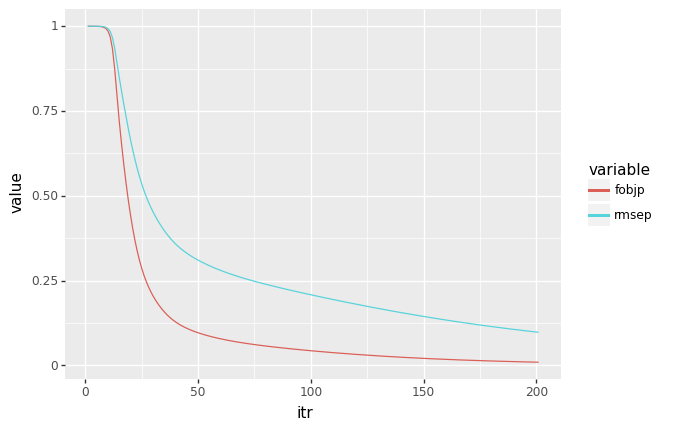

In [15]:
#Gradient descent
N = 200
alpha = 0.001
pred = np.round(np.dot(U, V.T), decimals=2)
fobj = [f(U, V)]
rmsej = [rmse(pred, train)]
maej = [mae(pred, train)]
start = time.time()
#process iteratively until we get to the bottom
for i in tqdm(range(N)):
    U = U - alpha*dfu(U)
    V = V - alpha*dfv(V)
    fobj.append(f(U, V))
    pred = np.round(np.dot(U, V.T), 2)
    rmsej.append(rmse(pred, train))
    maej.append(mae(pred, train))
    
print('Time difference of {} mins'.format((time.time() - start) / 60))
#fojb predicted values
fojb = np.array(fobj)
#rmsej actual observed values
rmsej = np.array(rmsej)
maej = np.array(maej)
path1 = pd.DataFrame({'itr': range(1, N+2), 'fobj': fobj, 'fobjp': fobj/max(fobj), 'rmse': rmsej, 'rmsep': rmsej/max(rmsej), 'mae': maej, 'maep': maej/max(maej)})
path1gg = pd.melt(path1[["itr", "fobjp", "rmsep"]], id_vars=['itr'])
print(path1.tail(1))

print(ggplot(path1gg, aes('itr', 'value', color = 'variable')) + geom_line())

In [23]:
# Export recommend games
user_dict = dict(users.values)
game_dict = {games.iloc[i, 0]: games.iloc[i, 1] for i in range(games.shape[0])}   #key: name vlaue: number

reverse_game_dict = {games.iloc[i, 1]: games.iloc[i, 0] for i in range(games.shape[0])}  #key: number  value: name
pred_percentile = pd.DataFrame(pred)
for i in range(pred_percentile.shape[0]):
    pred_percentile.iloc[i,:] = pred_percentile.iloc[i,:].rank(method = 'first')
    
pred_percentile=pred_percentile.values
pred_percentile = np.argsort(-pred_percentile,axis=1)

In [24]:
def top(n, user, print_value=True):
    #Not consider the games has been purchsed
    not_purchased = (I- 1) % 2
    t_user = user
    user = user_dict[user]
    top_games = (pred_percentile*not_purchased).iloc[user]
    top_games = list(top_games[:n])
    if print_value:
        print('top {} recommended games for user {}: '.format(n, t_user))
        for i in range(n):
            print(i, ")", reverse_game_dict[top_games[i]])
    else:
        result = [t_user]
        for i in range(n):
            result.append(reverse_game_dict[top_games[i]])
        return result
    

In [25]:
top_N = 20
result = []
users_merge=users_test
for idx, user in tqdm(enumerate(users_merge['user'].values)):
    result.append(top(top_N, user, False))

users_not=users_test[~users_test['user'].isin(users_merge['user'])]
for user in users_not['user']:
    empty=[user]
    for i in range(top_N):
        empty.append(0)
    result.append(empty)
recommendations = pd.DataFrame(result)
columns = ['user_id'] + ['{}'.format(i+1) for i in range(top_N)]
recommendations.columns = columns
#recommendations.to_csv('D:\\HKU\\data mining\\Game-Recommendation-System-master\\data\\test\\Collaborative_EM_output.csv', index=None)

3181it [06:30,  8.15it/s]


In [26]:
dataTest =steam_test

def precision(n):
    dataOutputs = recommendations.copy()

    dataOutputs["numberGamesUserHasInTest"] = 0
    dataOutputs["numberRecommendationUserHas"] = 0
    dataOutputs["precision"] = 0

    for i, row in dataOutputs.iterrows():
        userGames = dataTest[dataTest["user"] == row["user_id"]]["game1"].tolist()
        dataOutputs.at[i, 'numberGamesUserHasInTest'] = len(userGames)
        count = 0
        for j in range(1, n+1):
            if row[j] in userGames:
                count += 1
        dataOutputs.at[i, "numberRecommendationUserHas"] = count
        if len(userGames) != 0:
            if len(userGames)<n:
                dataOutputs.at[i, "precision"] = float(count/len(userGames))
            else:
                dataOutputs.at[i, "precision"] = float(count/n)
    precision = dataOutputs["precision"].mean()
    return precision

precision(20)

0.26343348763831315

In [27]:
dataTest =steam_test
def recall(n):
    dataOutputs = recommendations.copy()
    
    dataOutputs["numberGamesUserHasInTest"] = 0
    dataOutputs["numberRecommendationUserHas"] = 0
    dataOutputs["recall"] = 0

    for i, row in dataOutputs.iterrows():
        userGames = dataTest[dataTest["user"] == row["user_id"]]["game1"].tolist()
        dataOutputs.at[i, 'numberGamesUserHasInTest'] = len(userGames)
        count = 0
        for j in range(1, n+1):
            if row[j] in userGames:
                count += 1
        dataOutputs.at[i, "numberRecommendationUserHas"] = count
        if len(userGames) != 0:
            dataOutputs.at[i, "recall"] = float(count/len(userGames))
    recall = dataOutputs["recall"].mean()
    return recall

recall(20)   

0.26342720030728517

In [28]:
def F1(n):
    P = precision(n)
    R = recall(n)
    F1 = 2*((P * R) / (P + R))
    return F1
F1(20)

0.263430343935284